<a href="https://colab.research.google.com/github/Ksenia-90/Machine_learning-_in_business/blob/my/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Урок 7. #Интерпретация прогнозов модели (SHAP) - объясняем поведение модели на отдельных наблюдениях##

##Домашнее задание##
Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

Feature selection:

RFE - recursive feature elimination (есть в sklearn)
Boruta - shadow features
Target permutation


In [62]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import  RandomForestClassifier
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [64]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [65]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [66]:
X = df.drop(['PassengerId', 'Survived', 'Name','Ticket','Cabin'], axis=1)
y = df.Survived

In [67]:
X = pd.get_dummies(X)

In [68]:
X = X.fillna({'Age': X.Age.median()})

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1)

In [70]:
import xgboost as xgb

In [71]:
model_1 = xgb.train(params = {"learning_rate": 0.01}, dtrain = xgb.DMatrix(X, label=y), num_boost_round = 100)

In [73]:
pip install shap

In [74]:
import shap

In [76]:
explainer = shap.TreeExplainer(model_1)

In [77]:
shap_values = explainer.shap_values(X)

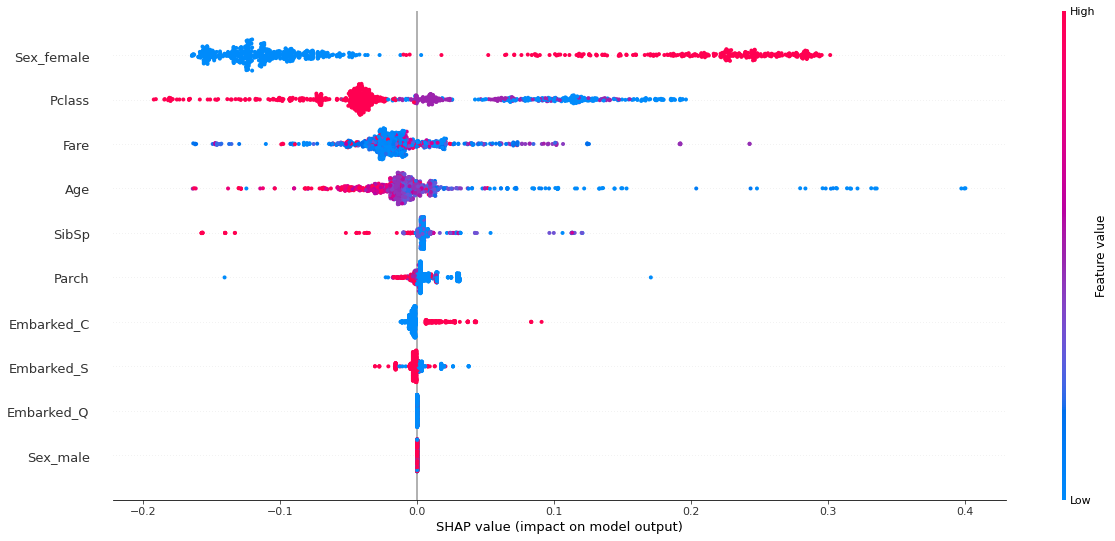

In [78]:
shap.initjs()
shap.summary_plot(shap_values, X, plot_size=(20,9))

In [80]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [81]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, features=X)